<a href="https://colab.research.google.com/github/sayanbanerjee32/TASI_ERAv2_S9/blob/main/S9_SayanBanerjee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import all required packages including local files

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchsummary import summary

import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2

import numpy as np

#import from local modules
from utils import Cifar10Dataset
from utils import train, test, checkpoint, resume
from utils import get_device, plot_accuracy_losses, plot_top_loss
# from models import Net

# Check if GPU available

In [2]:
# CUDA? - call get_device function defined in utils.py
is_cuda, device = get_device()

CUDA Available? True


# Visualising Train data

# Dataset and Creating Train/Test Split

In [3]:
train_data_raw = datasets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())

Files already downloaded and verified


In [4]:
# train data shape
print(train_data_raw.data.shape)
# train data mean
print(train_data_raw.data.mean(axis=(0,1,2))/255)
# train data standard deviation
print(train_data_raw.data.std(axis=(0,1,2))/255)

(50000, 32, 32, 3)
[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]


# Dataloader Arguments & Test/Train Dataloaders

In [5]:
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if is_cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader_raw = torch.utils.data.DataLoader(train_data_raw, **dataloader_args)

class_labels = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Data Visualization

torch.Size([128, 3, 32, 32])
torch.Size([128])


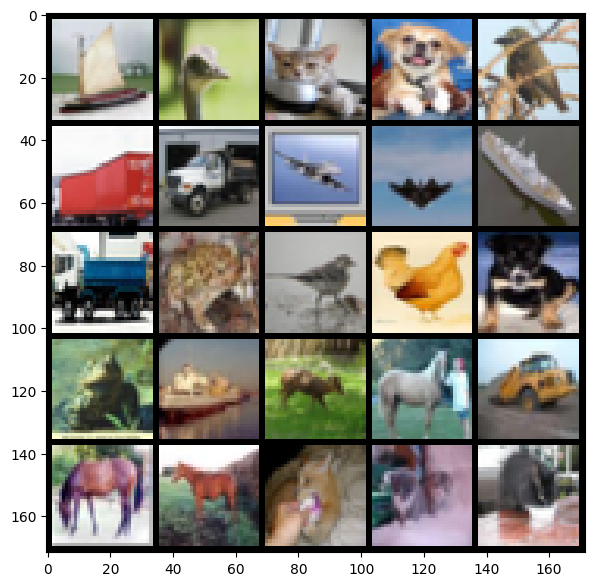

In [6]:
dataiter = iter(train_loader_raw)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Create a grid of images
grid = torchvision.utils.make_grid(images[:25], nrow=5)

# Display the grid
plt.figure(figsize=(7,7))
plt.imshow(grid.permute(1,2,0))
plt.show()

In [7]:
# how labels look like
print(' '.join(f'{class_labels[labels[j]]:5s}' for j in range(len(labels[:25]))))

ship  bird  cat   dog   bird  truck truck plane plane ship  truck frog  bird  bird  dog   frog  ship  deer  horse truck horse horse dog   cat   cat  


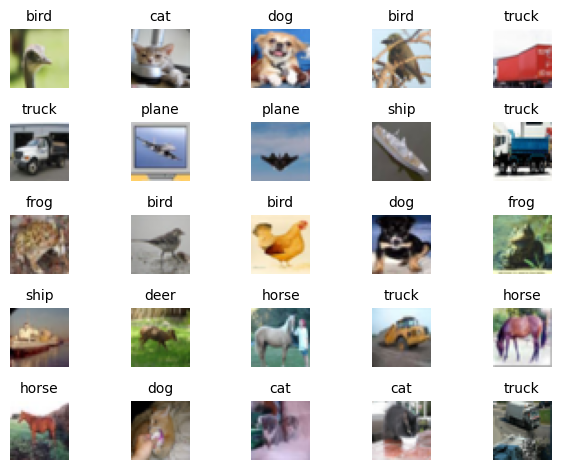

In [8]:
figure = plt.figure()
rows, cols = 5, 5
for index in range(1, cols * rows  + 1):
    plt.subplot(rows, cols, index)
    plt.title(class_labels[labels[index]],fontsize = 10)
    plt.axis('off')
    plt.imshow(images[index].permute(1, 2, 0))
figure.tight_layout()
plt.show()

# Train and Test transformations

In [9]:
# Train Phase transformations
train_transforms = A.Compose([
                                # A.RandomResizedCrop(p=0.5, height=32, width=32),
                                A.HorizontalFlip(p=0.5),
                                A.ShiftScaleRotate(p=0.5),
                                A.Normalize((0.4914,0.4822,0.4465), (0.247,0.243,0.262)),
                                # A.CoarseDropout(max_holes = 1, max_height=16, max_width=16, min_holes = 1, min_height=16, min_width=16,
                                #                 fill_value=[0.4914,0.4822,0.4465], mask_fill_value = None, p=0.5),
                                A.Compose([A.PadIfNeeded (min_height=64, min_width=64, p = 1.0),
                                            A.CoarseDropout(max_holes = 1, max_height=16, max_width=16, min_holes = 1, min_height=16, min_width=16,
                                                fill_value=[0.4914,0.4822,0.4465], mask_fill_value = None, p=1),
                                           A.CenterCrop(height=32, width=32, p=1),
                                ], p = 1),
                                ToTensorV2(),
                                ])

# Test Phase transformations
test_transforms = A.Compose([
                            A.Normalize((0.4914,0.4822,0.4465), (0.247,0.243,0.262)),
                            ToTensorV2(),
                            ])

# Dataset and Creating Train/Test Split

In [10]:
# train_data = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
# test_data = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)
train_data = Cifar10Dataset(transform=train_transforms)
test_data = Cifar10Dataset(train=False, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
train_data

Dataset Cifar10Dataset
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose([
             HorizontalFlip(always_apply=False, p=0.5),
             ShiftScaleRotate(always_apply=False, p=0.5, shift_limit_x=(-0.0625, 0.0625), shift_limit_y=(-0.0625, 0.0625), scale_limit=(-0.09999999999999998, 0.10000000000000009), rotate_limit=(-45, 45), interpolation=1, border_mode=4, value=None, mask_value=None, rotate_method='largest_box'),
             Normalize(always_apply=False, p=1.0, mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.262), max_pixel_value=255.0),
             Compose([
               PadIfNeeded(always_apply=False, p=1.0, min_height=64, min_width=64, pad_height_divisor=None, pad_width_divisor=None, border_mode=4, value=None, mask_value=None),
               CoarseDropout(always_apply=False, p=1, max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16, min_width=16, fill_value=[0.4914, 0.4822, 0.4465], m

# Dataloader Arguments & Test/Train Dataloaders

In [12]:
# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

### Augmented data visualization

torch.Size([128, 3, 32, 32])
torch.Size([128])


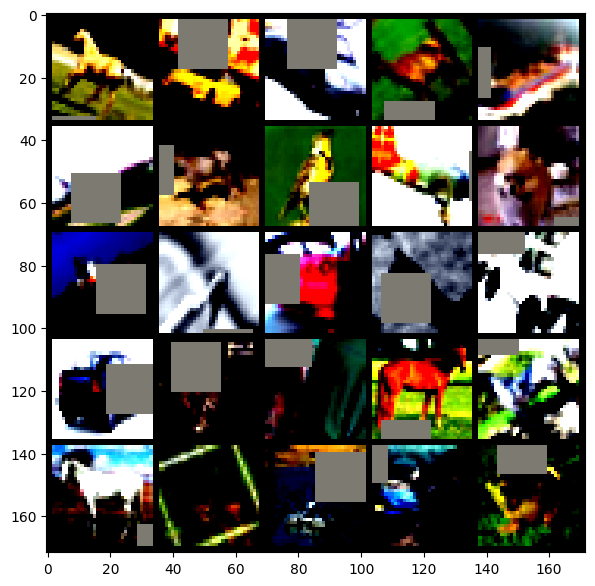

In [13]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Create a grid of images
grid = torchvision.utils.make_grid(images[:25], nrow=5)

# Display the grid
plt.figure(figsize=(7,7))
plt.imshow(grid.permute(1,2,0))
plt.show()

# Training

In [14]:
class Net(nn.Module):
    def __init__(self, dropout_value = 0.1):
        super(Net, self).__init__()
        # # Input Block / CONVOLUTION BLOCK 1
        self.C1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) #input size: 32 x 32 x 3, output size: 32 x 32 x 32, receptive field: 1 + (3-1) * 1 = 3


        self.C2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) #input size: 32 x 32 x 32, output size: 32 x 32 x 64, receptive field: 3 + (3-1) * 1 = 5

        ## Strided convolution
        self.SC1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32,
                      kernel_size=(3, 3), padding=1, stride = 2, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) #input size: 32 x 32 x n*2, output size: 24 x 24 x n*4, receptive field: 3 + (3-1) * 1 = 5
        #Lout =  (Lin + 2 * padding - dilation * (kernel - 1) - 1) / stride + 1
        # ((32 + 2 * 1 - 1 * (3 - 1) -1) / 2) + 1 = 16

        # # ## dilated convolution
        # self.SC1 = nn.Sequential(
        #     nn.Conv2d(in_channels=32, out_channels=32,
        #               kernel_size=(3, 3), padding=0, dilation = 6, bias=False),
        #     nn.ReLU(),
        #     nn.BatchNorm2d(32),
        #     nn.Dropout(dropout_value)
        # ) #input size: 32 x 32 x n*2, output size: 24 x 24 x n*4, receptive field: 3 + (3-1) * 1 = 5
        # # ((32 + 2 * 1 - 8 * (3 - 1) -1) / 1) + 1 = 25

        # # TRANSITION BLOCK 1
        # self.t1 = nn.Sequential(
        #     nn.Conv2d(in_channels=32, out_channels=16,
        #               kernel_size=(1, 1), padding=0, bias=False),
        #     nn.ReLU(),
        #     nn.BatchNorm2d(16),
        #     nn.Dropout(dropout_value)
        # ) #input size: 17 x 17 x n*4, output size: 17 x 17 x n, receptive field: 6 + (1-1)*2 = 6


        # CONVOLUTION BLOCK 2
        self.C3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) #input size: 16 x 16 x n, output size: 16 x 16 x n*2, receptive field: 6 + (3-1) * 2 = 10

        self.C4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) #input size: 16 x 16 x n*2, output size: 16 x 16 x n*4, receptive field: 10 + (3-1) * 2 = 14

        self.C4_1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) #input size: 16 x 16 x n*2, output size: 16 x 16 x n*4, receptive field: 10 + (3-1) * 2 = 14


        self.SC2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64,
                      kernel_size=(3, 3), padding=1, stride = 2, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) #input size: 16 x 16 x n*4, output size: 16 x 16 x n*4, receptive field: 14 + (3-1) * 2 = 18

        # self.SC2 = nn.Sequential(
        #     nn.Conv2d(in_channels=64, out_channels=64,
        #               kernel_size=(3, 3), padding=0, dilation = 4, bias=False),
        #     nn.ReLU(),
        #     nn.BatchNorm2d(64),
        #     nn.Dropout(dropout_value)
        # ) #input size: 16 x 16 x n*4, output size: 16 x 16 x n*4, receptive field: 14 + (3-1) * 2 = 18
        # ((18 + 2 * 1 - 4 * (3 - 1) -1) / 1) + 1 = 12
        # TRANSITION BLOCK 2
        self.t2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32,
                      kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) #input size: 16 x 16 x n*4, output size: 16 x 16 x n, receptive field: 18 + (1-1)*2 = 18

        # CONVOLUTION BLOCK 3
        # self.C5 = nn.Sequential(
        #     nn.Conv2d(in_channels=32, out_channels=64,
        #               kernel_size=(3, 3), padding=1, bias=False),
        #     nn.ReLU(),
        #     nn.BatchNorm2d(64),
        #     nn.Dropout(dropout_value)
        # ) #input size: 16 x 16 x n, output size: 16 x 16 x n*2, receptive field: 6 + (3-1) * 2 = 10

        # self.C6 = nn.Sequential(
        #     nn.Conv2d(in_channels=64, out_channels=128,
        #               kernel_size=(3, 3), padding=1, bias=False),
        #     nn.ReLU(),
        #     nn.BatchNorm2d(128),
        #     nn.Dropout(dropout_value)
        # ) #input size: 16 x 16 x n*2, output size: 16 x 16 x n*4, receptive field: 10 + (3-1) * 2 = 14
        self.C5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, groups = 32,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) #input size: 16 x 16 x n, output size: 16 x 16 x n*2, receptive field: 6 + (3-1) * 2 = 10

        self.C6 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, groups = 64,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) #input size: 16 x 16 x n*2, output size: 16 x 16 x n*4, receptive field: 10 + (3-1) * 2 = 14

        self.C7 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, groups = 64,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) #input size: 16 x 16 x n*2, output size: 16 x 16 x n*4, receptive field: 10 + (3-1) * 2 = 14

        self.SC3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64,
                      kernel_size=(3, 3), padding=1, stride = 2, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) #input size: 16 x 16 x n*4, output size: 16 x 16 x n*4, receptive field: 14 + (3-1) * 2 = 18
        # self.SC3 = nn.Sequential(
        #     nn.Conv2d(in_channels=64, out_channels=64,
        #               kernel_size=(3, 3), padding=0, dilation = 2, bias=False),
        #     nn.ReLU(),
        #     nn.BatchNorm2d(64),
        #     nn.Dropout(dropout_value)
        # ) #input size: 16 x 16 x n*4, output size: 16 x 16 x n*4, receptive field: 14 + (3-1) * 2 = 18
        # # ((12 + 2 * 1 - 4 * (3 - 1) -1) / 1) + 1 = 11
        # TRANSITION BLOCK 3
        self.t3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32,
                      kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) #input size: 16 x 16 x n*4, output size: 16 x 16 x n, receptive field: 18 + (1-1)*2 = 18

        # CONVOLUTION BLOCK 4

        # self.C7 = nn.Sequential(
        #     nn.Conv2d(in_channels=32, out_channels=64,
        #               kernel_size=(3, 3), padding=1, bias=False),
        #     nn.ReLU(),
        #     nn.BatchNorm2d(64),
        #     nn.Dropout(dropout_value)
        # ) #input size: 8 x 8 x n, output size: 8 x 8 x n*2, receptive field: 20 + (3-1) * 4 = 28

        # self.C8 = nn.Sequential(
        #     nn.Conv2d(in_channels=64, out_channels=128,
        #               kernel_size=(3, 3), padding=1, bias=False),
        #     nn.ReLU(),
        #     nn.BatchNorm2d(128),
        #     nn.Dropout(dropout_value)
        # ) #input size: 8 x 8 x n*2, output size: 8 x 8 x n*4, receptive field: 28 + (3-1) * 4 = 36

        self.C8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, groups = 32,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) #input size: 8 x 8 x n, output size: 8 x 8 x n*2, receptive field: 20 + (3-1) * 4 = 28

        self.C9 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, groups = 64,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(dropout_value)
        ) #input size: 8 x 8 x n*2, output size: 8 x 8 x n*4, receptive field: 28 + (3-1) * 4 = 36

        self.C10 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, groups = 128,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(dropout_value)
        ) #input size: 8 x 8 x n*4, output size: 8 x 8 x n*4, receptive field: 36 + (3-1) * 4 = 44

        # OUTPUT BLOCK
        self.GAP = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1))
        ) #input size: 8 x 8 x n*4, output size: 1 x 1 x n*4, receptive field: 44

        self.c11 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=10,
                      kernel_size=(1, 1), padding=0, bias=False),
        ) #input size: 1 x 1 x n*4, output size: 1 x 1 x 10, receptive field: 44 + (1-1) * 4 =44



    def forward(self, x):
        x = self.C1(x)
        x = x + self.C2(x)

        x = self.SC1(x)
        # x = self.t1(x)

        x = self.C3(x)
        x = self.C4(x)
        x = x + self.C4_1(x)

        x = self.SC2(x)
        x = self.t2(x)

        x = self.C5(x)
        x = self.C6(x)
        x = x + self.C7(x)

        x = self.SC3(x)
        x = self.t3(x)

        x = self.C8(x)
        x = self.C9(x)
        x = self.C10(x)

        x = self.GAP(x)
        x = self.c11(x)

        x = x.squeeze()

        return F.log_softmax(x, dim=-1)

In [15]:
# visualise model parameters
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 32, 16, 16]           9,216
             ReLU-10           [-1, 32, 16, 16]               0
      BatchNorm2d-11           [-1, 32, 16, 16]              64
          Dropout-12           [-1, 32, 16, 16]               0
           Conv2d-13           [-1, 64, 16, 16]          18,432
             ReLU-14           [-1, 64,

strided - 641,248 - 51% - 74%  
Dilated - 641,248 - 47% - 68%

197,152
with random resized crop
61% - 75% (56 e) - 53% - 69% (20e)

wo
dilated - 65% - 74% (20 e)  
        76% - 81% (72 e)

In [16]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

In [17]:
current_learning_rate = 0.1
optimizer = optim.SGD(model.parameters(), lr=current_learning_rate, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer  = optimizer,
                                                 mode = 'min',
                                                 factor = 0.1,
                                                 min_lr = 0.0001,
                                                 threshold_mode  = 'rel',
                                                 threshold = 0.0001,
                                                 patience  = 3,
                                                 verbose = True)
criterion = F.nll_loss
num_epochs = 100
early_stopping_patience = 10
best_test_loss = np.inf
best_epoch = -1

for epoch in range(1, num_epochs+1):
    print(f'Epoch {epoch}')
    # call train function from utils.py
    trn_acc, trn_loss = train(model, device, train_loader, optimizer, criterion)
    # accumulate train accuracies and test losses for visualisation
    train_acc.append(trn_acc)
    train_losses.append(trn_loss)

    # call test function from utils.py
    tst_acc, tst_loss = test(model, device, test_loader, criterion)
    # accumulate test accuracies and test losses for visualisation
    test_acc.append(tst_acc)
    test_losses.append(tst_loss)

    scheduler.step(tst_loss)
    if current_learning_rate != scheduler.get_last_lr()[0]:
        current_learning_rate = scheduler.get_last_lr()[0]
        print(f'Learning rate updated to: {current_learning_rate}')

    # early stopping
    if tst_loss < best_test_loss:
        best_test_loss = tst_loss
        best_epoch = epoch
        checkpoint(model, "best_model.pth")
    elif epoch - best_epoch > early_stopping_patience:
        print("Early stopped training at epoch %d" % epoch)
        break  # terminate the training loop

resume(model, "best_model.pth")

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1


Train: Loss=1.6678 Batch_id=390 Accuracy=33.73: 100%|██████████| 391/391 [00:25<00:00, 15.13it/s]


Test set: Average loss: 1.5380, Accuracy: 4316/10000 (43.16%)

Epoch 2


Train: Loss=1.6653 Batch_id=390 Accuracy=42.68: 100%|██████████| 391/391 [00:17<00:00, 21.87it/s]


Test set: Average loss: 1.3709, Accuracy: 4935/10000 (49.35%)

Epoch 3


Train: Loss=1.4490 Batch_id=390 Accuracy=46.53: 100%|██████████| 391/391 [00:18<00:00, 21.60it/s]


Test set: Average loss: 1.2236, Accuracy: 5622/10000 (56.22%)

Epoch 4


Train: Loss=1.3938 Batch_id=390 Accuracy=50.33: 100%|██████████| 391/391 [00:18<00:00, 21.46it/s]


Test set: Average loss: 1.1389, Accuracy: 5896/10000 (58.96%)

Epoch 5


Train: Loss=1.4048 Batch_id=390 Accuracy=52.94: 100%|██████████| 391/391 [00:18<00:00, 21.68it/s]


Test set: Average loss: 1.1205, Accuracy: 5980/10000 (59.80%)

Epoch 6


Train: Loss=1.2118 Batch_id=390 Accuracy=55.53: 100%|██████████| 391/391 [00:20<00:00, 19.51it/s]


Test set: Average loss: 0.9672, Accuracy: 6545/10000 (65.45%)

Epoch 7


Train: Loss=1.2609 Batch_id=390 Accuracy=57.56: 100%|██████████| 391/391 [00:18<00:00, 21.41it/s]


Test set: Average loss: 0.9290, Accuracy: 6766/10000 (67.66%)

Epoch 8


Train: Loss=1.4321 Batch_id=390 Accuracy=59.18: 100%|██████████| 391/391 [00:20<00:00, 19.53it/s]


Test set: Average loss: 0.8895, Accuracy: 6861/10000 (68.61%)

Epoch 9


Train: Loss=1.1504 Batch_id=390 Accuracy=60.62: 100%|██████████| 391/391 [00:19<00:00, 20.02it/s]


Test set: Average loss: 0.8637, Accuracy: 6927/10000 (69.27%)

Epoch 10


Train: Loss=0.9641 Batch_id=390 Accuracy=61.74: 100%|██████████| 391/391 [00:20<00:00, 19.00it/s]


Test set: Average loss: 0.8392, Accuracy: 7037/10000 (70.37%)

Epoch 11


Train: Loss=0.9925 Batch_id=390 Accuracy=63.17: 100%|██████████| 391/391 [00:19<00:00, 20.13it/s]


Test set: Average loss: 0.7983, Accuracy: 7123/10000 (71.23%)

Epoch 12


Train: Loss=1.0081 Batch_id=390 Accuracy=63.98: 100%|██████████| 391/391 [00:19<00:00, 20.01it/s]


Test set: Average loss: 0.7778, Accuracy: 7335/10000 (73.35%)

Epoch 13


Train: Loss=1.0815 Batch_id=390 Accuracy=65.23: 100%|██████████| 391/391 [00:20<00:00, 19.09it/s]


Test set: Average loss: 0.7346, Accuracy: 7453/10000 (74.53%)

Epoch 14


Train: Loss=0.9522 Batch_id=390 Accuracy=66.01: 100%|██████████| 391/391 [00:19<00:00, 20.22it/s]


Test set: Average loss: 0.7133, Accuracy: 7550/10000 (75.50%)

Epoch 15


Train: Loss=0.8254 Batch_id=390 Accuracy=66.97: 100%|██████████| 391/391 [00:20<00:00, 19.39it/s]


Test set: Average loss: 0.7023, Accuracy: 7578/10000 (75.78%)

Epoch 16


Train: Loss=1.0994 Batch_id=390 Accuracy=67.54: 100%|██████████| 391/391 [00:19<00:00, 20.35it/s]


Test set: Average loss: 0.7065, Accuracy: 7585/10000 (75.85%)

Epoch 17


Train: Loss=0.9986 Batch_id=390 Accuracy=68.27: 100%|██████████| 391/391 [00:19<00:00, 19.88it/s]


Test set: Average loss: 0.6710, Accuracy: 7697/10000 (76.97%)

Epoch 18


Train: Loss=1.0152 Batch_id=390 Accuracy=68.69: 100%|██████████| 391/391 [00:21<00:00, 18.18it/s]


Test set: Average loss: 0.6666, Accuracy: 7690/10000 (76.90%)

Epoch 19


Train: Loss=0.9465 Batch_id=390 Accuracy=69.59: 100%|██████████| 391/391 [00:19<00:00, 20.22it/s]


Test set: Average loss: 0.6348, Accuracy: 7843/10000 (78.43%)

Epoch 20


Train: Loss=0.9730 Batch_id=390 Accuracy=70.22: 100%|██████████| 391/391 [00:20<00:00, 19.20it/s]


Test set: Average loss: 0.6125, Accuracy: 7876/10000 (78.76%)

Epoch 21


Train: Loss=0.7289 Batch_id=390 Accuracy=70.22: 100%|██████████| 391/391 [00:19<00:00, 19.87it/s]


Test set: Average loss: 0.6251, Accuracy: 7807/10000 (78.07%)

Epoch 22


Train: Loss=0.8324 Batch_id=390 Accuracy=70.51: 100%|██████████| 391/391 [00:19<00:00, 20.27it/s]


Test set: Average loss: 0.6123, Accuracy: 7886/10000 (78.86%)

Epoch 23


Train: Loss=0.9483 Batch_id=390 Accuracy=70.79: 100%|██████████| 391/391 [00:20<00:00, 19.23it/s]


Test set: Average loss: 0.5965, Accuracy: 7928/10000 (79.28%)

Epoch 24


Train: Loss=0.9053 Batch_id=390 Accuracy=71.43: 100%|██████████| 391/391 [00:19<00:00, 20.15it/s]


Test set: Average loss: 0.5852, Accuracy: 7991/10000 (79.91%)

Epoch 25


Train: Loss=0.7335 Batch_id=390 Accuracy=71.74: 100%|██████████| 391/391 [00:19<00:00, 20.10it/s]


Test set: Average loss: 0.5777, Accuracy: 8001/10000 (80.01%)

Epoch 26


Train: Loss=0.8627 Batch_id=390 Accuracy=72.05: 100%|██████████| 391/391 [00:18<00:00, 21.43it/s]


Test set: Average loss: 0.5813, Accuracy: 8022/10000 (80.22%)

Epoch 27


Train: Loss=0.9804 Batch_id=390 Accuracy=72.21: 100%|██████████| 391/391 [00:18<00:00, 21.30it/s]


Test set: Average loss: 0.5550, Accuracy: 8101/10000 (81.01%)

Epoch 28


Train: Loss=0.8096 Batch_id=390 Accuracy=72.77: 100%|██████████| 391/391 [00:20<00:00, 19.48it/s]


Test set: Average loss: 0.5598, Accuracy: 8046/10000 (80.46%)

Epoch 29


Train: Loss=0.7838 Batch_id=390 Accuracy=72.87: 100%|██████████| 391/391 [00:17<00:00, 21.74it/s]


Test set: Average loss: 0.5379, Accuracy: 8211/10000 (82.11%)

Epoch 30


Train: Loss=0.8194 Batch_id=390 Accuracy=73.23: 100%|██████████| 391/391 [00:19<00:00, 20.44it/s]


Test set: Average loss: 0.5658, Accuracy: 8094/10000 (80.94%)

Epoch 31


Train: Loss=0.8389 Batch_id=390 Accuracy=73.52: 100%|██████████| 391/391 [00:18<00:00, 21.34it/s]


Test set: Average loss: 0.5287, Accuracy: 8256/10000 (82.56%)

Epoch 32


Train: Loss=0.6525 Batch_id=390 Accuracy=73.80: 100%|██████████| 391/391 [00:19<00:00, 20.35it/s]


Test set: Average loss: 0.5276, Accuracy: 8193/10000 (81.93%)

Epoch 33


Train: Loss=0.5283 Batch_id=390 Accuracy=74.15: 100%|██████████| 391/391 [00:18<00:00, 21.64it/s]


Test set: Average loss: 0.5057, Accuracy: 8335/10000 (83.35%)

Epoch 34


Train: Loss=0.7531 Batch_id=390 Accuracy=74.47: 100%|██████████| 391/391 [00:19<00:00, 20.33it/s]


Test set: Average loss: 0.5308, Accuracy: 8209/10000 (82.09%)

Epoch 35


Train: Loss=0.9887 Batch_id=390 Accuracy=74.51: 100%|██████████| 391/391 [00:18<00:00, 21.56it/s]


Test set: Average loss: 0.5332, Accuracy: 8185/10000 (81.85%)

Epoch 36


Train: Loss=0.6624 Batch_id=390 Accuracy=74.51: 100%|██████████| 391/391 [00:19<00:00, 20.28it/s]


Test set: Average loss: 0.5215, Accuracy: 8225/10000 (82.25%)

Epoch 37


Train: Loss=0.9355 Batch_id=390 Accuracy=74.94: 100%|██████████| 391/391 [00:18<00:00, 21.66it/s]


Test set: Average loss: 0.5068, Accuracy: 8273/10000 (82.73%)

Learning rate updated to: 0.010000000000000002
Epoch 38


Train: Loss=0.5942 Batch_id=390 Accuracy=76.84: 100%|██████████| 391/391 [00:19<00:00, 20.27it/s]


Test set: Average loss: 0.4676, Accuracy: 8412/10000 (84.12%)

Epoch 39


Train: Loss=0.7113 Batch_id=390 Accuracy=77.19: 100%|██████████| 391/391 [00:19<00:00, 20.23it/s]


Test set: Average loss: 0.4546, Accuracy: 8458/10000 (84.58%)

Epoch 40


Train: Loss=0.5979 Batch_id=390 Accuracy=77.44: 100%|██████████| 391/391 [00:18<00:00, 20.92it/s]


Test set: Average loss: 0.4514, Accuracy: 8474/10000 (84.74%)

Epoch 41


Train: Loss=0.6132 Batch_id=390 Accuracy=77.75: 100%|██████████| 391/391 [00:18<00:00, 21.20it/s]


Test set: Average loss: 0.4591, Accuracy: 8456/10000 (84.56%)

Epoch 42


Train: Loss=0.6018 Batch_id=390 Accuracy=77.63: 100%|██████████| 391/391 [00:18<00:00, 20.97it/s]


Test set: Average loss: 0.4469, Accuracy: 8505/10000 (85.05%)

Epoch 43


Train: Loss=0.6623 Batch_id=390 Accuracy=77.89: 100%|██████████| 391/391 [00:20<00:00, 19.18it/s]


Test set: Average loss: 0.4438, Accuracy: 8486/10000 (84.86%)

Epoch 44


Train: Loss=0.6515 Batch_id=390 Accuracy=77.97: 100%|██████████| 391/391 [00:19<00:00, 20.33it/s]


Test set: Average loss: 0.4393, Accuracy: 8517/10000 (85.17%)

Epoch 45


Train: Loss=0.6464 Batch_id=390 Accuracy=78.27: 100%|██████████| 391/391 [00:20<00:00, 18.94it/s]


Test set: Average loss: 0.4388, Accuracy: 8489/10000 (84.89%)

Epoch 46


Train: Loss=0.6167 Batch_id=390 Accuracy=77.96: 100%|██████████| 391/391 [00:19<00:00, 20.05it/s]


Test set: Average loss: 0.4414, Accuracy: 8509/10000 (85.09%)

Epoch 47


Train: Loss=0.7068 Batch_id=390 Accuracy=78.02: 100%|██████████| 391/391 [00:19<00:00, 20.16it/s]


Test set: Average loss: 0.4363, Accuracy: 8539/10000 (85.39%)

Epoch 48


Train: Loss=0.5372 Batch_id=390 Accuracy=78.01: 100%|██████████| 391/391 [00:20<00:00, 19.03it/s]


Test set: Average loss: 0.4365, Accuracy: 8523/10000 (85.23%)

Epoch 49


Train: Loss=0.4896 Batch_id=390 Accuracy=78.44: 100%|██████████| 391/391 [00:20<00:00, 19.05it/s]


Test set: Average loss: 0.4323, Accuracy: 8537/10000 (85.37%)

Epoch 50


Train: Loss=0.5599 Batch_id=390 Accuracy=78.16: 100%|██████████| 391/391 [00:19<00:00, 19.74it/s]


Test set: Average loss: 0.4369, Accuracy: 8545/10000 (85.45%)

Epoch 51


Train: Loss=0.6324 Batch_id=390 Accuracy=78.34: 100%|██████████| 391/391 [00:20<00:00, 19.07it/s]


Test set: Average loss: 0.4284, Accuracy: 8568/10000 (85.68%)

Epoch 52


Train: Loss=0.8136 Batch_id=390 Accuracy=78.03: 100%|██████████| 391/391 [00:19<00:00, 20.03it/s]


Test set: Average loss: 0.4298, Accuracy: 8552/10000 (85.52%)

Epoch 53


Train: Loss=0.7313 Batch_id=390 Accuracy=78.44: 100%|██████████| 391/391 [00:20<00:00, 19.11it/s]


Test set: Average loss: 0.4278, Accuracy: 8558/10000 (85.58%)

Epoch 54


Train: Loss=0.4543 Batch_id=390 Accuracy=78.65: 100%|██████████| 391/391 [00:20<00:00, 19.50it/s]


Test set: Average loss: 0.4306, Accuracy: 8545/10000 (85.45%)

Epoch 55


Train: Loss=0.6044 Batch_id=390 Accuracy=78.39: 100%|██████████| 391/391 [00:19<00:00, 19.82it/s]


Test set: Average loss: 0.4317, Accuracy: 8546/10000 (85.46%)

Epoch 56


Train: Loss=0.6777 Batch_id=390 Accuracy=78.25: 100%|██████████| 391/391 [00:20<00:00, 18.94it/s]


Test set: Average loss: 0.4307, Accuracy: 8540/10000 (85.40%)

Epoch 57


Train: Loss=0.5915 Batch_id=390 Accuracy=78.31: 100%|██████████| 391/391 [00:19<00:00, 19.99it/s]


Test set: Average loss: 0.4255, Accuracy: 8548/10000 (85.48%)

Epoch 58


Train: Loss=0.7021 Batch_id=390 Accuracy=78.60: 100%|██████████| 391/391 [00:19<00:00, 19.83it/s]


Test set: Average loss: 0.4285, Accuracy: 8550/10000 (85.50%)

Epoch 59


Train: Loss=0.7179 Batch_id=390 Accuracy=78.40: 100%|██████████| 391/391 [00:20<00:00, 19.20it/s]


Test set: Average loss: 0.4272, Accuracy: 8562/10000 (85.62%)

Epoch 60


Train: Loss=0.5407 Batch_id=390 Accuracy=78.81: 100%|██████████| 391/391 [00:18<00:00, 21.29it/s]


Test set: Average loss: 0.4273, Accuracy: 8565/10000 (85.65%)

Epoch 61


Train: Loss=0.6292 Batch_id=390 Accuracy=78.74: 100%|██████████| 391/391 [00:19<00:00, 20.13it/s]


Test set: Average loss: 0.4224, Accuracy: 8555/10000 (85.55%)

Epoch 62


Train: Loss=0.5751 Batch_id=390 Accuracy=78.64: 100%|██████████| 391/391 [00:18<00:00, 21.06it/s]


Test set: Average loss: 0.4224, Accuracy: 8585/10000 (85.85%)

Epoch 63


Train: Loss=0.5969 Batch_id=390 Accuracy=78.51: 100%|██████████| 391/391 [00:19<00:00, 20.22it/s]


Test set: Average loss: 0.4275, Accuracy: 8556/10000 (85.56%)

Epoch 64


Train: Loss=0.7304 Batch_id=390 Accuracy=78.86: 100%|██████████| 391/391 [00:18<00:00, 21.62it/s]


Test set: Average loss: 0.4245, Accuracy: 8560/10000 (85.60%)

Epoch 65


Train: Loss=0.6239 Batch_id=390 Accuracy=78.73: 100%|██████████| 391/391 [00:23<00:00, 16.33it/s]


Test set: Average loss: 0.4280, Accuracy: 8550/10000 (85.50%)

Learning rate updated to: 0.0010000000000000002
Epoch 66


Train: Loss=0.5864 Batch_id=390 Accuracy=78.77: 100%|██████████| 391/391 [00:19<00:00, 19.56it/s]


Test set: Average loss: 0.4204, Accuracy: 8572/10000 (85.72%)

Epoch 67


Train: Loss=0.4103 Batch_id=390 Accuracy=78.90: 100%|██████████| 391/391 [00:17<00:00, 21.72it/s]


Test set: Average loss: 0.4203, Accuracy: 8592/10000 (85.92%)

Epoch 68


Train: Loss=0.7405 Batch_id=390 Accuracy=79.11: 100%|██████████| 391/391 [00:19<00:00, 20.26it/s]


Test set: Average loss: 0.4178, Accuracy: 8580/10000 (85.80%)

Epoch 69


Train: Loss=0.5624 Batch_id=390 Accuracy=79.43: 100%|██████████| 391/391 [00:19<00:00, 20.25it/s]


Test set: Average loss: 0.4208, Accuracy: 8560/10000 (85.60%)

Epoch 70


Train: Loss=0.6644 Batch_id=390 Accuracy=78.95: 100%|██████████| 391/391 [00:20<00:00, 19.48it/s]


Test set: Average loss: 0.4200, Accuracy: 8571/10000 (85.71%)

Epoch 71


Train: Loss=0.7448 Batch_id=390 Accuracy=79.24: 100%|██████████| 391/391 [00:21<00:00, 18.41it/s]


Test set: Average loss: 0.4210, Accuracy: 8578/10000 (85.78%)

Epoch 72


Train: Loss=0.7942 Batch_id=390 Accuracy=78.97: 100%|██████████| 391/391 [00:19<00:00, 20.44it/s]


Test set: Average loss: 0.4208, Accuracy: 8571/10000 (85.71%)

Learning rate updated to: 0.00010000000000000003
Epoch 73


Train: Loss=0.6654 Batch_id=390 Accuracy=78.90: 100%|██████████| 391/391 [00:20<00:00, 19.24it/s]


Test set: Average loss: 0.4202, Accuracy: 8582/10000 (85.82%)

Epoch 74


Train: Loss=0.5797 Batch_id=390 Accuracy=79.06: 100%|██████████| 391/391 [00:21<00:00, 18.62it/s]


Test set: Average loss: 0.4191, Accuracy: 8569/10000 (85.69%)

Epoch 75


Train: Loss=0.5028 Batch_id=390 Accuracy=79.26: 100%|██████████| 391/391 [00:19<00:00, 19.85it/s]


Test set: Average loss: 0.4200, Accuracy: 8571/10000 (85.71%)

Epoch 76


Train: Loss=0.4408 Batch_id=390 Accuracy=79.53: 100%|██████████| 391/391 [00:20<00:00, 19.17it/s]


Test set: Average loss: 0.4188, Accuracy: 8594/10000 (85.94%)

Epoch 77


Train: Loss=0.5508 Batch_id=390 Accuracy=79.05: 100%|██████████| 391/391 [00:23<00:00, 16.76it/s]


Test set: Average loss: 0.4180, Accuracy: 8565/10000 (85.65%)

Epoch 78


Train: Loss=0.6624 Batch_id=390 Accuracy=78.93: 100%|██████████| 391/391 [00:19<00:00, 19.83it/s]


Test set: Average loss: 0.4189, Accuracy: 8580/10000 (85.80%)

Epoch 79


Train: Loss=0.5563 Batch_id=390 Accuracy=79.25: 100%|██████████| 391/391 [00:21<00:00, 17.80it/s]


Test set: Average loss: 0.4187, Accuracy: 8574/10000 (85.74%)

Early stopped training at epoch 79


In [18]:
# final learning rate
scheduler.get_last_lr()

[0.00010000000000000003]

## Visualise training and test losses and accuracies

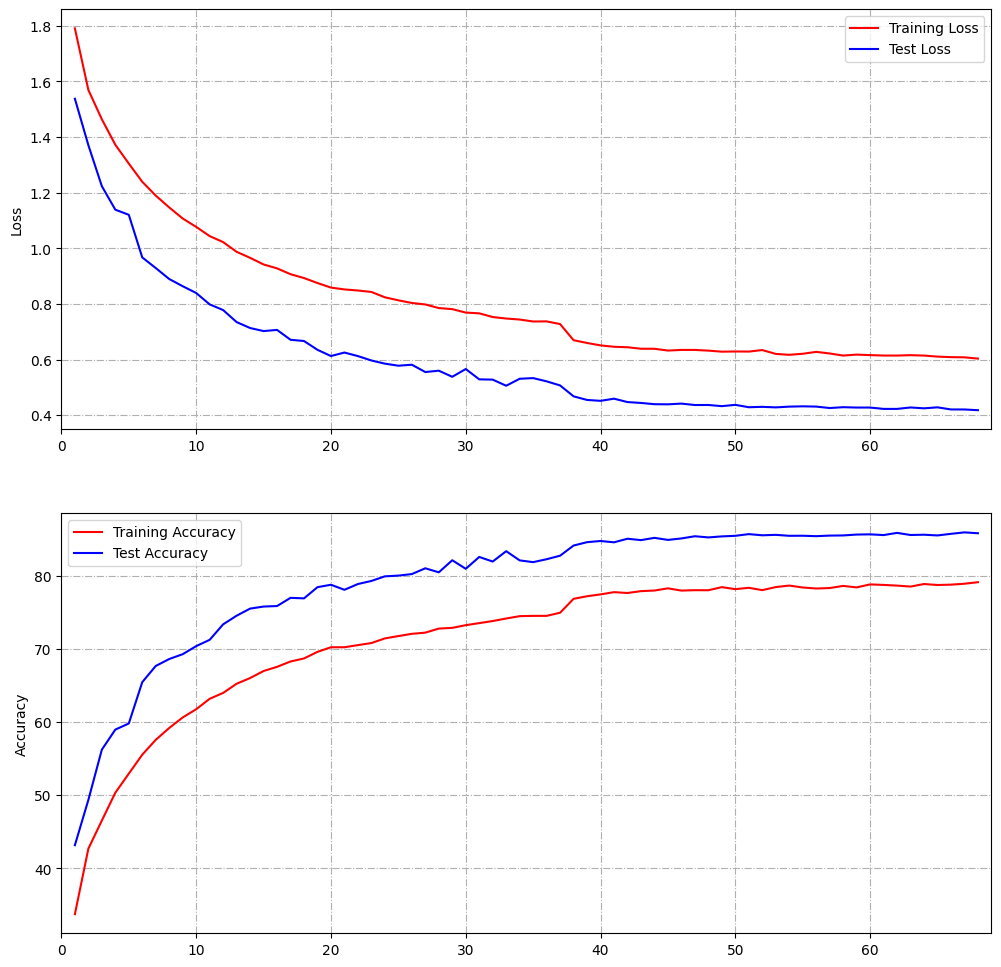

In [19]:
## use function from utils.py
plot_accuracy_losses(train_losses, train_acc, test_losses, test_acc, best_epoch)

## Error analysis

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


total wrong predictions: 1420


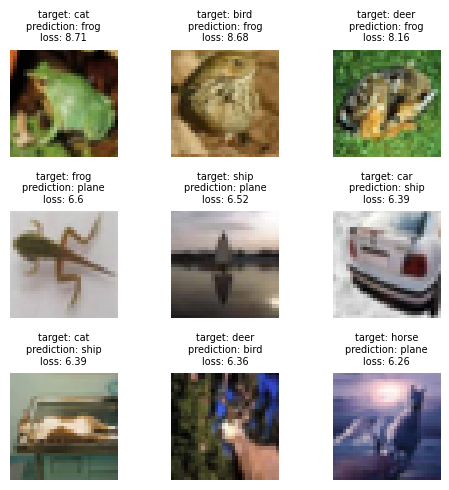

In [22]:
incr_groups_df = plot_top_loss(model, device, test_loader, criterion,
                               label_names = class_labels, img_rows=3, img_cols = 3)

In [21]:
incr_groups_df.loc[incr_groups_df.image > 1]

,target,prediction,loss,image
32,dog,cat,1.603071,126
18,cat,dog,1.367036,79
6,bird,plane,1.508624,57
2,bird,deer,2.092916,52
19,cat,frog,1.942244,50
...,...,...,...,...
63,ship,bird,2.754119,3
0,bird,car,2.881809,2
67,ship,frog,3.776730,2
9,car,bird,3.073963,2
